In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeMontreal, FakeToronto, FakeSydney
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
fake_montreal = FakeMontreal()
qcomp_sim_M = AerSimulator.from_backend(fake_montreal)
fake_montreal

<FakeMontreal('fake_montreal') from None()>

In [4]:
fake_toronto = FakeToronto()
qcomp_sim_T = AerSimulator.from_backend(fake_toronto)
fake_toronto

<FakeToronto('fake_toronto') from None()>

In [5]:
fake_sydney = FakeSydney()
qcomp_sim_S = AerSimulator.from_backend(fake_sydney)
fake_sydney

<FakeSydney('fake_sydney') from None()>

In [6]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación
def cod(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 6
    qubits sobre un grafo conocido en la literatura como "Red Mariposa"
    fuera de orden usando un circuito construido mediante la teoría de 
    QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(6, 'q')
    if creg:
        cr = ClassicalRegister(4, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h(qr[0])
    qc.h(qr[1])
    qc.h(qr[2])

    qc.barrier()

    qc.cnot(1, 4)
    qc.barrier()
    qc.cnot(4, 3)
    qc.barrier()
    qc.cnot(4, 5)
    qc.barrier()
    qc.cnot([0, 2], [1, 5])
    qc.barrier()
    qc.cnot([0, 2], [3, 1])

    qc.barrier()

    qc.h(4)
    #qc.measure([1, 4], [2, 3])

    qc.barrier()

    qc.cx([1, 1],[3, 5])
    qc.cz([4, 4],[3, 5])

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito:  10


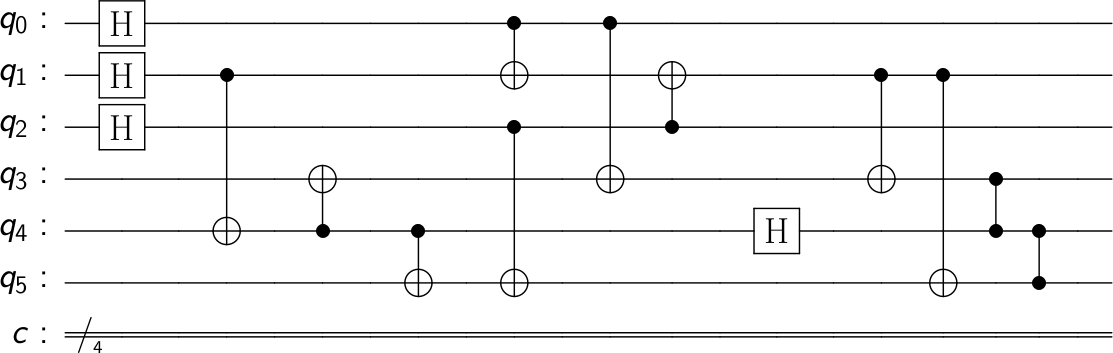

None

In [7]:
qc = cod()
display(qc.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito: ", qc.depth()))


In [ ]:
Statevector&([ 0.25+0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.25+0.j,\\
           &   0.  +0.j,  0.25+0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,\\
           &  -0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,\\
           &   0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.25+0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.25+0.j,\\
           &   0.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,\\
           &   0.  +0.j,  0.25+0.j,  0.  +0.j, -0.25+0.j],\\
           & dims=(2, 2, 2, 2, 2, 2))

Statevector([ 0.25+0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.25+0.j,
              0.  +0.j,  0.25+0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,
             -0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,
              0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.25+0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.25+0.j,
              0.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
              0.  +0.j,  0.25+0.j,  0.  +0.j, -0.25+0.j],
            dims=(2, 2, 2, 2, 2, 2))


None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


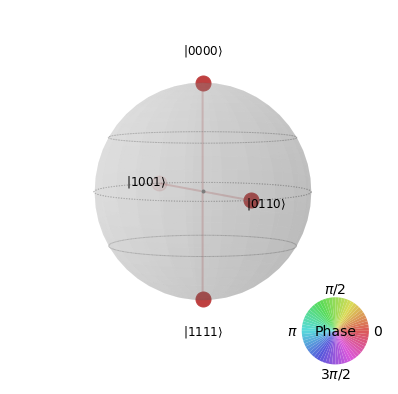

In [8]:
svs = BasicAer.get_backend('statevector_simulator')
qc_svs = execute(qc, svs).result()
qc_P  = qi.partial_trace(qi.DensityMatrix(qc_svs.get_statevector(qc)), [1, 4])
qc_sv = qi.Statevector.from_instruction(qc)
display(print(qc_sv),
        #psi.draw(output='qsphere'),
        qc_P.draw(output='qsphere'),
        # plot_state_city(Ro_psi),
        #plot_state_hinton(psi)
       )


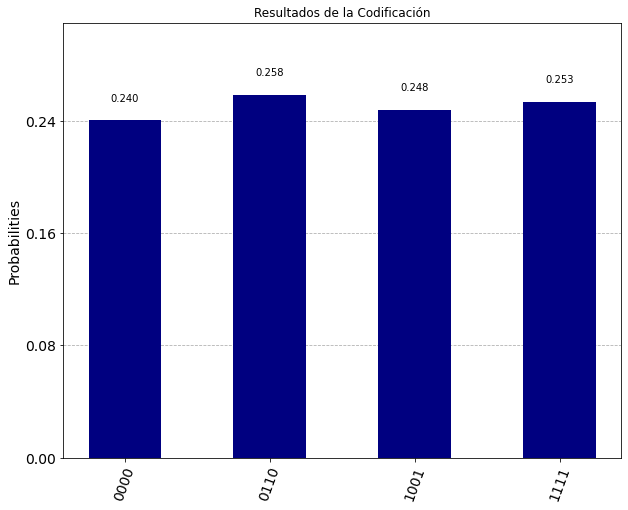

In [9]:
qc_meas = qc.copy()
qc_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
sim = Aer.get_backend('qasm_simulator')
results = execute(qc_meas, backend = sim, shots = shots).result()
counts = results.get_counts()
plth(counts,
     title='Resultados de la Codificación',
     color=[
            'navy'
           ],
     figsize=(10, 8)
)

In [27]:
print(counts)
for i in counts:
    print(i, ': ',counts[i], '/',round(counts[i]/shots, 5))

{'0110': 2116, '1111': 2075, '1001': 2032, '0000': 1969}
0110 :  2116 / 0.2583
1111 :  2075 / 0.2533
1001 :  2032 / 0.24805
0000 :  1969 / 0.24036


In [11]:
# Transpile the circuit for the noisy sistem's basis gates
tqc_sim_m = transpile(cod(False), qcomp_sim_M,)
#tqc_sim_m_sv = qi.Statevector.from_instruction(tqc_sim_m)
tqc_sim_m_meas = transpile(qc_meas, qcomp_sim_M)

tqc_sim_t = transpile(cod(False), qcomp_sim_T)
#tqc_sim_t_sv = qi.Statevector.from_instruction(tqc_sim_t)
tqc_sim_t_meas = transpile(qc_meas, qcomp_sim_T)

tqc_sim_s = transpile(cod(False), qcomp_sim_S)
#tqc_sim_s_sv = qi.Statevector.from_instruction(tqc_sim_s)
tqc_sim_s_meas = transpile(qc_meas, qcomp_sim_S)




Profundidad del Circuito usando el modelo de prueba:
  50


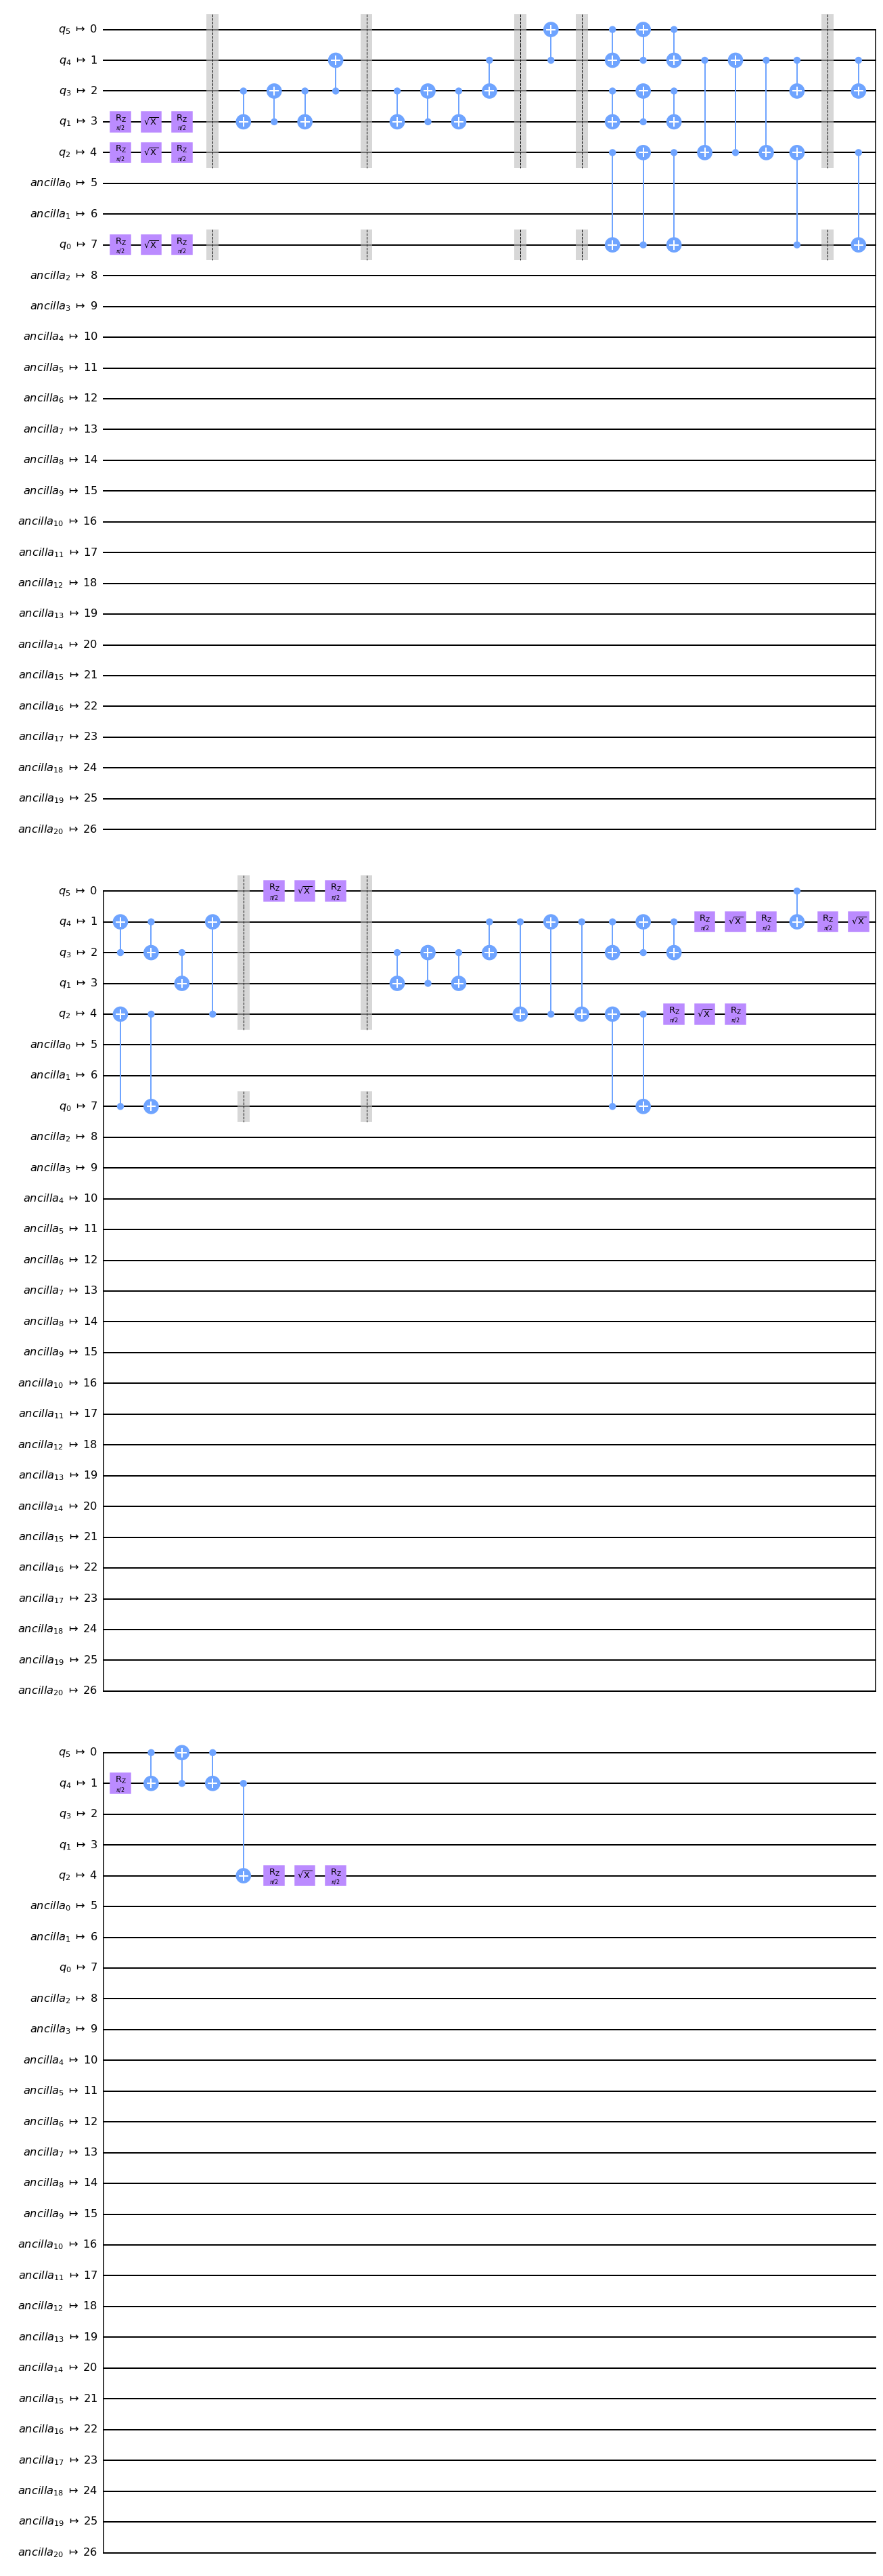

None

In [14]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_m.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_m_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_m.depth()))




Profundidad del Circuito usando el modelo de prueba:
  43


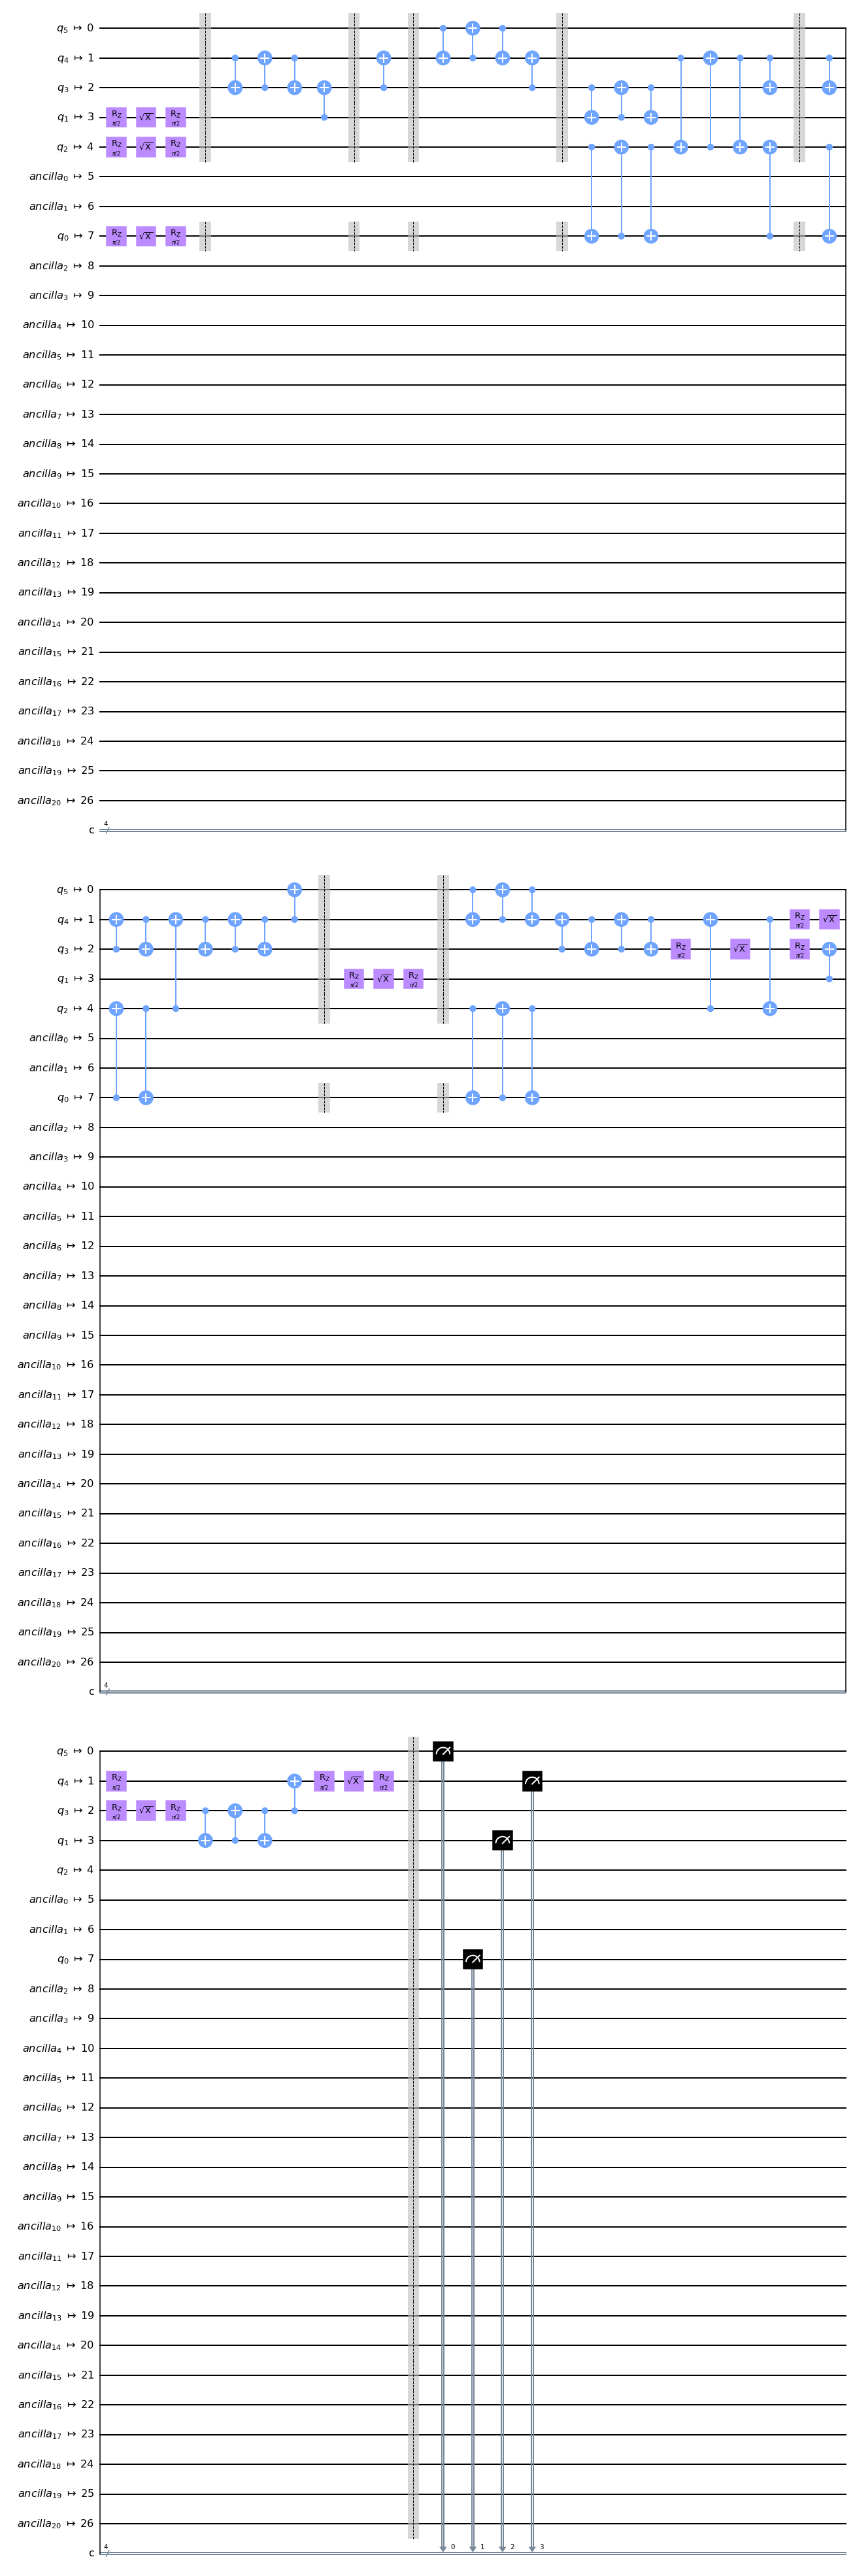

None

In [15]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_t_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_t_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_t.depth()))




Profundidad del Circuito usando el modelo de prueba:
  46


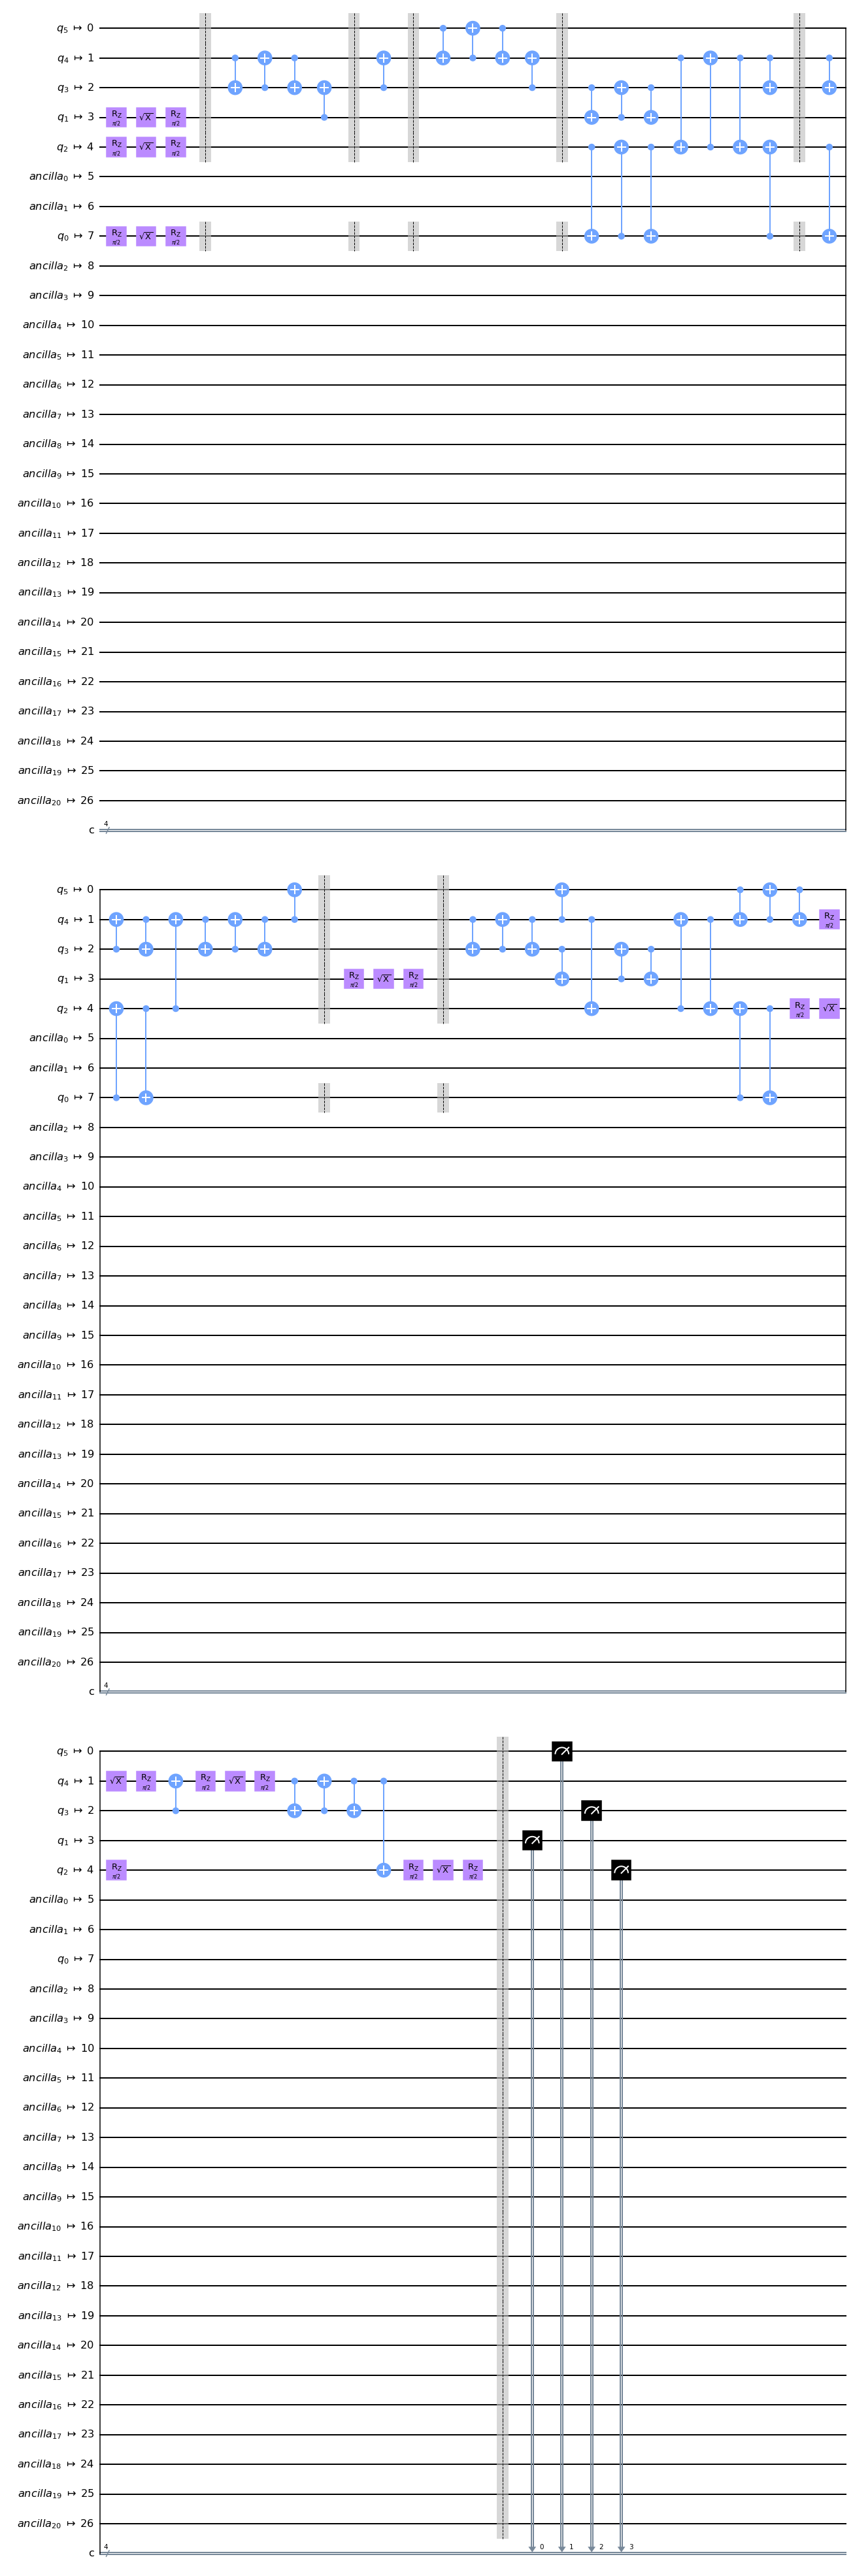

None

In [16]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_s_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_s_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_s.depth()))


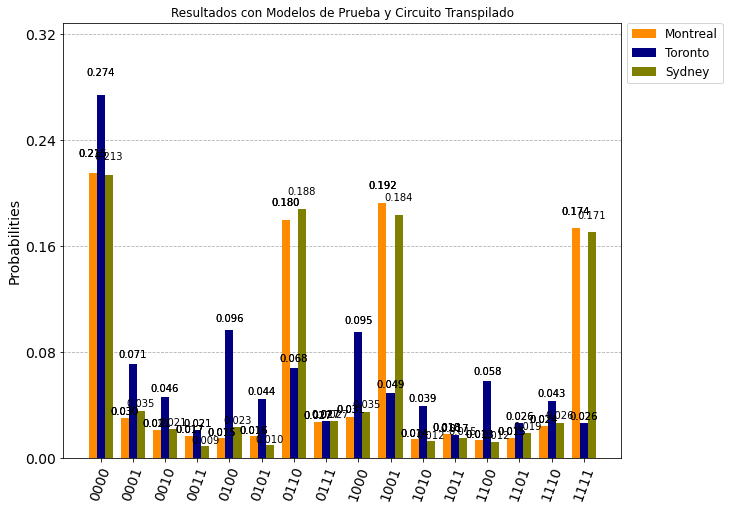

In [12]:
# Execute noisy simulation on dummys and get counts
result_noise_sim_m = qcomp_sim_M.run(tqc_sim_m_meas, shots=shots).result()
result_noise_sim_t = qcomp_sim_T.run(tqc_sim_t_meas, shots=shots).result()
result_noise_sim_s = qcomp_sim_S.run(tqc_sim_s_meas, shots=shots).result()

counts_noise_sim_m = result_noise_sim_m.get_counts(tqc_sim_m_meas)
counts_noise_sim_t = result_noise_sim_t.get_counts(tqc_sim_t_meas)
counts_noise_sim_s = result_noise_sim_s.get_counts(tqc_sim_s_meas)

plth(
    [counts_noise_sim_m,
     counts_noise_sim_t,
     counts_noise_sim_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Transpilado',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [23]:
print('Cuentas de la codificación con "Montreal": \n', counts_noise_sim_m)
for i in counts_noise_sim_m:
    print(i, ': ',counts_noise_sim_m[i], '/',counts_noise_sim_m[i]/shots)
print('\nCuentas de la codificación con "Toronto": \n', counts_noise_sim_t)
for i in counts_noise_sim_t:
    print(i, ': ',counts_noise_sim_t[i], '/',counts_noise_sim_t[i]/shots)
print('\nCuentas de la codificación con "Sydney": \n', counts_noise_sim_s)
for i in counts_noise_sim_s:
    print(i, ': ',counts_noise_sim_s[i], '/',counts_noise_sim_s[i]/shots)


Cuentas de la codificación con "Montreal": 
 {'1000': 252, '0000': 1761, '0110': 1473, '1111': 1424, '1001': 1574, '0100': 120, '0010': 169, '1011': 149, '0001': 245, '1100': 108, '1110': 193, '0101': 132, '0111': 220, '0011': 136, '1101': 123, '1010': 113}
1000 :  252 / 0.03076171875
0000 :  1761 / 0.2149658203125
0110 :  1473 / 0.1798095703125
1111 :  1424 / 0.173828125
1001 :  1574 / 0.192138671875
0100 :  120 / 0.0146484375
0010 :  169 / 0.0206298828125
1011 :  149 / 0.0181884765625
0001 :  245 / 0.0299072265625
1100 :  108 / 0.01318359375
1110 :  193 / 0.0235595703125
0101 :  132 / 0.01611328125
0111 :  220 / 0.02685546875
0011 :  136 / 0.0166015625
1101 :  123 / 0.0150146484375
1010 :  113 / 0.0137939453125

Cuentas de la codificación con "Toronto": 
 {'1100': 477, '1010': 319, '0001': 581, '1110': 349, '0111': 224, '0000': 2243, '1000': 777, '1101': 212, '1011': 142, '0010': 378, '0110': 556, '0101': 362, '1001': 402, '0100': 788, '1111': 213, '0011': 169}
1100 :  477 / 0.058227

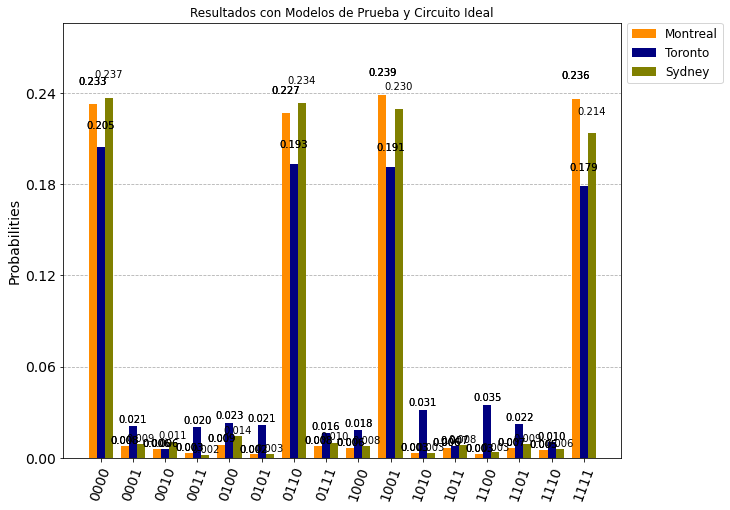

In [15]:
# Execute noisy simulation on dummys and get counts
result_noise_m = qcomp_sim_M.run(qc_meas, shots=shots).result()
result_noise_t = qcomp_sim_T.run(qc_meas, shots=shots).result()
result_noise_s = qcomp_sim_S.run(qc_meas, shots=shots).result()

counts_noise_m = result_noise_m.get_counts(qc_meas)
counts_noise_t = result_noise_t.get_counts(qc_meas)
counts_noise_s = result_noise_s.get_counts(qc_meas)

plth(
    [counts_noise_m,
     counts_noise_t,
     counts_noise_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [26]:
for i in range(len(counts_noise_m)):
    print('{0:04b}'.format(i), ' ',counts_noise_m['{0:04b}'.format(i)], '/',
          round(counts_noise_m['{0:04b}'.format(i)]/shots, 5), ' ',
          counts_noise_t['{0:04b}'.format(i)], '/',
          round(counts_noise_t['{0:04b}'.format(i)]/shots, 5), ' ',
          counts_noise_s['{0:04b}'.format(i)], '/',
          round(counts_noise_s['{0:04b}'.format(i)]/shots, 5), ' '
         )

0000   1907 / 0.23279   1678 / 0.20483   1941 / 0.23694  
0001   64 / 0.00781   171 / 0.02087   73 / 0.00891  
0010   46 / 0.00562   47 / 0.00574   87 / 0.01062  
0011   25 / 0.00305   164 / 0.02002   17 / 0.00208  
0100   70 / 0.00854   189 / 0.02307   116 / 0.01416  
0101   18 / 0.0022   175 / 0.02136   21 / 0.00256  
0110   1860 / 0.22705   1584 / 0.19336   1914 / 0.23364  
0111   64 / 0.00781   134 / 0.01636   81 / 0.00989  
1000   53 / 0.00647   150 / 0.01831   64 / 0.00781  
1001   1955 / 0.23865   1567 / 0.19128   1881 / 0.22961  
1010   25 / 0.00305   257 / 0.03137   27 / 0.0033  
1011   52 / 0.00635   61 / 0.00745   69 / 0.00842  
1100   22 / 0.00269   283 / 0.03455   28 / 0.00342  
1101   54 / 0.00659   182 / 0.02222   74 / 0.00903  
1110   40 / 0.00488   85 / 0.01038   47 / 0.00574  
1111   1937 / 0.23645   1465 / 0.17883   1752 / 0.21387  


In [22]:
print('Cuentas de la codificación simulada con "Montreal": \n', counts_noise_m)
for i in counts_noise_m:
    print(i, ': ',counts_noise_m[i], '/',counts_noise_m[i]/shots)
print('\nCuentas de la codificación simulada con "Toronto": \n', counts_noise_t)
for i in counts_noise_t:
    print(i, ': ',counts_noise_t[i], '/',counts_noise_t[i]/shots)
print('\nCuentas de la codificación simulada con "Sydney": \n', counts_noise_s)
for i in counts_noise_s:
    print(i, ': ',counts_noise_s[i], '/',counts_noise_s[i]/shots)


Cuentas de la codificación simulada con "Montreal": 
 {'0110': 1860, '1111': 1937, '1010': 25, '1001': 1955, '0000': 1907, '0010': 46, '0100': 70, '1101': 54, '1011': 52, '0011': 25, '0101': 18, '1000': 53, '1110': 40, '0111': 64, '0001': 64, '1100': 22}
0110 :  1860 / 0.22705078125
1111 :  1937 / 0.2364501953125
1010 :  25 / 0.0030517578125
1001 :  1955 / 0.2386474609375
0000 :  1907 / 0.2327880859375
0010 :  46 / 0.005615234375
0100 :  70 / 0.008544921875
1101 :  54 / 0.006591796875
1011 :  52 / 0.00634765625
0011 :  25 / 0.0030517578125
0101 :  18 / 0.002197265625
1000 :  53 / 0.0064697265625
1110 :  40 / 0.0048828125
0111 :  64 / 0.0078125
0001 :  64 / 0.0078125
1100 :  22 / 0.002685546875

Cuentas de la codificación simulada con "Toronto": 
 {'0110': 1584, '1111': 1465, '1010': 257, '1001': 1567, '0011': 164, '1100': 283, '0000': 1678, '0101': 175, '1011': 61, '1101': 182, '1000': 150, '0100': 189, '1110': 85, '0001': 171, '0111': 134, '0010': 47}
0110 :  1584 / 0.193359375
1111 :

In [136]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_M,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_m = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_m_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = {:.5f}'.format(F_sim_m))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = 0.48801
                                            (c/ corrección): F = 0.60126


Tiempo de ejecución [minutos] (s/ corrección): t = 3.23966
                              (c/ corrección): t = 3.70815


Tiempo transcurrido [segundos] : t = 665.90695


In [137]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_T,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_t = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_t_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = {:.5f}'.format(F_sim_t))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_t_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = 0.05988
                                            (c/ corrección): F = 0.07038


Tiempo de ejecución [minutos] (s/ corrección): t = 1.13122
                              (c/ corrección): t = 1.30582


Tiempo transcurrido [segundos] : t = 498.45126


In [138]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_S,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_s = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_s_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = {:.5f}'.format(F_sim_s))
print('                                           (c/ corrección): F = {:.5f}'.format(F_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = 0.44140
                                           (c/ corrección): F = 0.54490


Tiempo de ejecución [minutos] (s/ corrección): t = 3.22095
                              (c/ corrección): t = 3.89589


Tiempo transcurrido [segundos] : t = 661.19318


In [18]:
# RUIDOS

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'cz', 'sx', 'x', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'cz', 'sx', 'x', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'cz', 'sx', 'x', 'u3']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


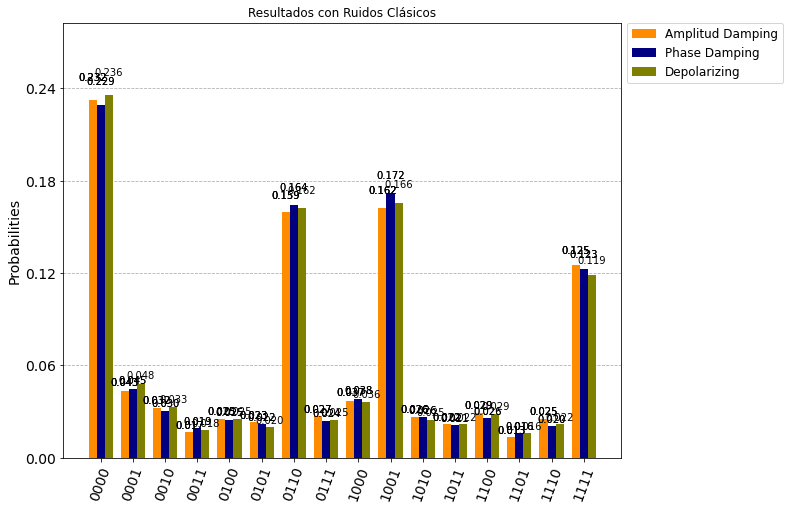

In [19]:
# Simular el Ruido de Amplitud Damping
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)

tqc_noise_amp = transpile(qc, sim_noise_amp)
tqc_noise_phs = transpile(qc, sim_noise_phs)
tqc_noise_dprz = transpile(qc, sim_noise_dprz)

tqc_noise_amp_meas = tqc_noise_amp.copy()
tqc_noise_amp_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_amp = sim_noise_amp.run(tqc_noise_amp_meas, shots=shots).result()

tqc_noise_phs_meas = tqc_noise_phs.copy()
tqc_noise_phs_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_phs = sim_noise_amp.run(tqc_noise_phs_meas, shots=shots).result()

tqc_noise_dprz_meas = tqc_noise_dprz.copy()
tqc_noise_dprz_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_dprz = sim_noise_amp.run(tqc_noise_dprz_meas, shots=shots).result()

counts_noise_amp = result_noise_amp.get_counts(tqc_noise_amp_meas)
counts_noise_phs = result_noise_phs.get_counts(tqc_noise_phs_meas)
counts_noise_dprz = result_noise_dprz.get_counts(tqc_noise_dprz_meas)

plth(
    [counts_noise_amp,
     counts_noise_phs,
     counts_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados con Ruidos Clásicos',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [21]:
print('Cuentas de la codificación con Amp Dmp: \n', counts_noise_amp)
for i in counts_noise_amp:
    print(i, ': ',counts_noise_amp[i], '/',counts_noise_amp[i]/shots)
print('\nCuentas de la codificación con Phs Dmp: \n', counts_noise_phs)
for i in counts_noise_phs:
    print(i, ': ',counts_noise_phs[i], '/',counts_noise_phs[i]/shots)
print('\nCuentas de la codificación con Dprz: \n', counts_noise_dprz)
for i in counts_noise_dprz:
    print(i, ': ',counts_noise_dprz[i], '/',counts_noise_dprz[i]/shots)


Cuentas de la codificación con Amp Dmp: 
 {'0000': 1903, '0110': 1306, '1111': 1026, '1100': 240, '0001': 356, '1001': 1328, '1101': 110, '0010': 265, '1011': 177, '0100': 207, '0011': 137, '0101': 190, '1110': 207, '1000': 304, '1010': 216, '0111': 220}
0000 :  1903 / 0.2322998046875
0110 :  1306 / 0.159423828125
1111 :  1026 / 0.125244140625
1100 :  240 / 0.029296875
0001 :  356 / 0.04345703125
1001 :  1328 / 0.162109375
1101 :  110 / 0.013427734375
0010 :  265 / 0.0323486328125
1011 :  177 / 0.0216064453125
0100 :  207 / 0.0252685546875
0011 :  137 / 0.0167236328125
0101 :  190 / 0.023193359375
1110 :  207 / 0.0252685546875
1000 :  304 / 0.037109375
1010 :  216 / 0.0263671875
0111 :  220 / 0.02685546875

Cuentas de la codificación con Phs Dmp: 
 {'1000': 313, '0000': 1880, '1001': 1407, '1010': 214, '0001': 365, '0111': 196, '1011': 173, '1100': 209, '0010': 249, '1111': 1007, '0110': 1346, '0100': 202, '0101': 178, '1110': 166, '0011': 156, '1101': 131}
1000 :  313 / 0.038208007812

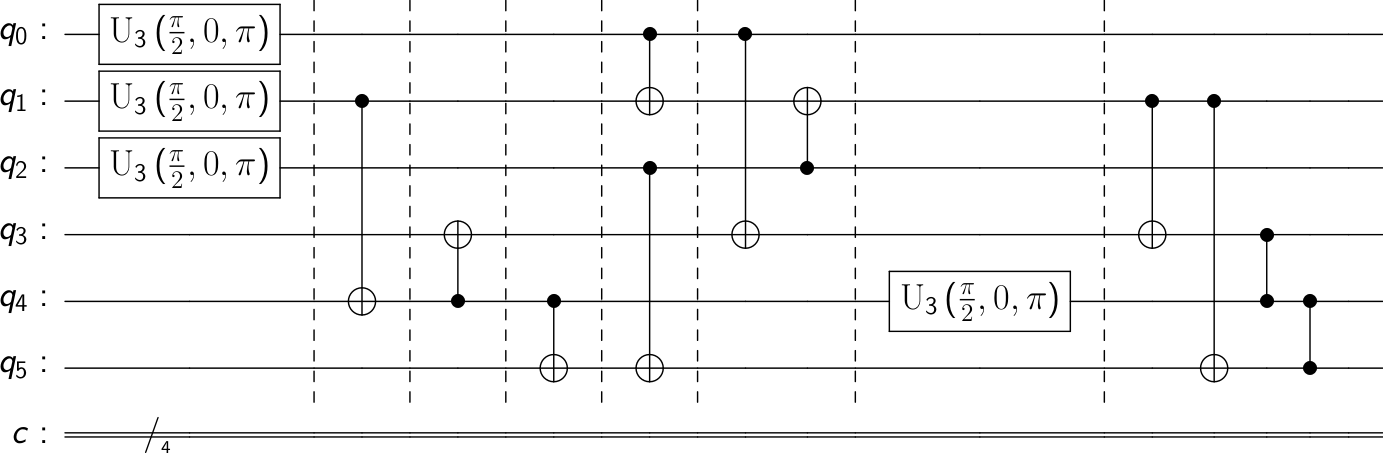

In [141]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_amp.draw('latex')

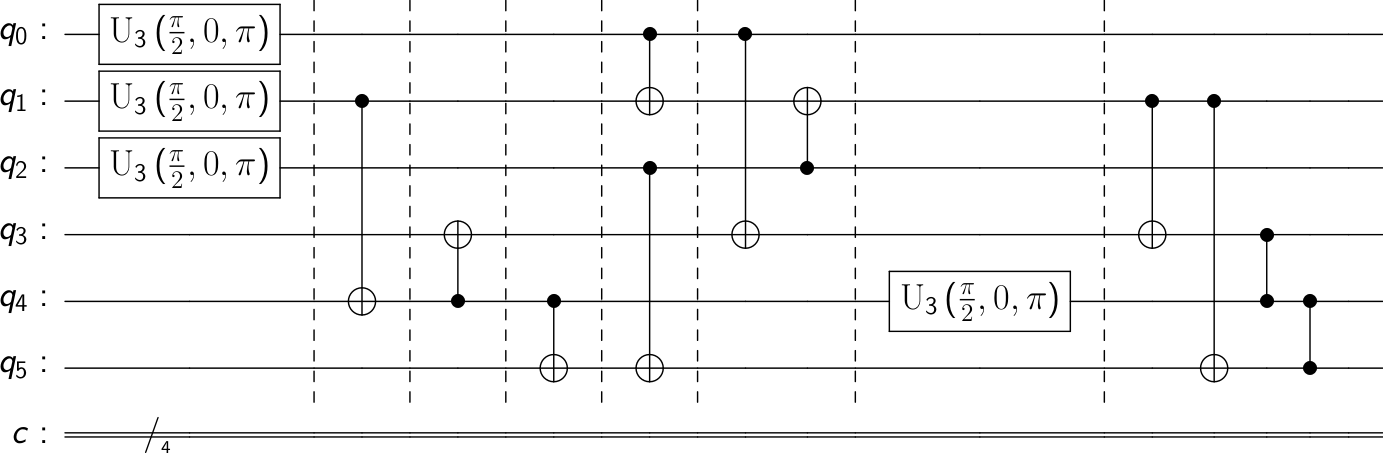

In [142]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_phs.draw('latex')

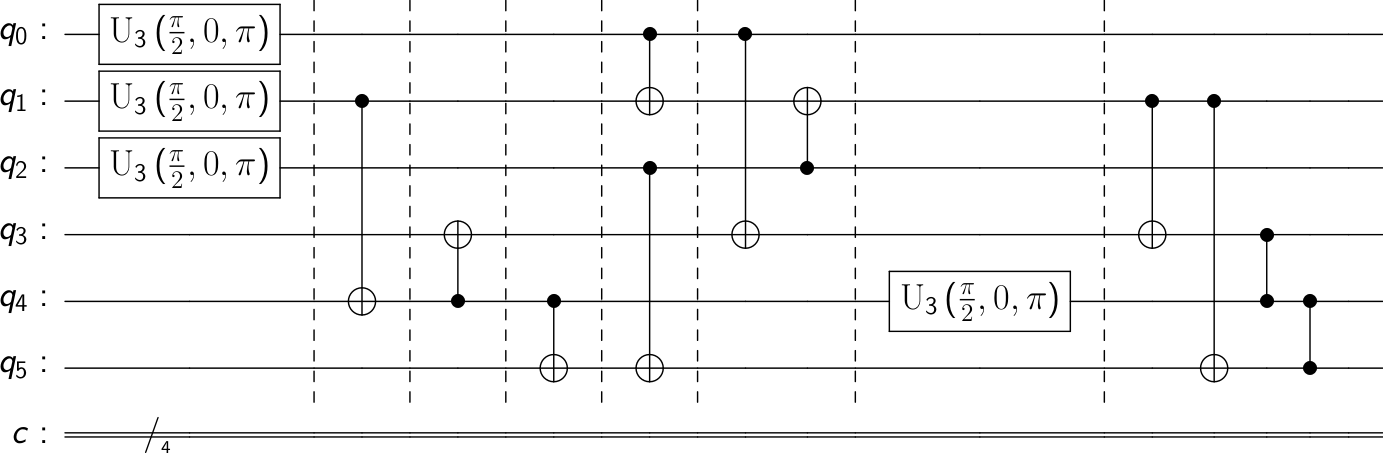

In [143]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_dprz.draw('latex')

In [144]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_sim_m = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_m_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_sim_m))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_sim_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.47964
                                                   (c/ corrección): F = 0.59576


Tiempo de ejecución [minutos] (s/ corrección): t = 0.45098
                              (c/ corrección): t = 0.47386


Tiempo transcurrido [segundos] : t = 388.76655


In [145]:
t = time.time()

P_phs = tomo(qc=cod(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = 0.72443
                                                (c/ corrección): F = 0.72443


Tiempo de ejecución [minutos] (s/ corrección): t = 0.28092
                              (c/ corrección): t = 0.41148


Tiempo transcurrido [segundos] : t = 440.69485


In [146]:
t = time.time()

P_dprz = tomo(qc=cod(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_dprz_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.47172
                                                   (c/ corrección): F = 0.52871


Tiempo de ejecución [minutos] (s/ corrección): t = 0.41035
                              (c/ corrección): t = 0.53906


Tiempo transcurrido [segundos] : t = 462.00222


In [147]:
f_amp = fid(qc, tqc_noise_amp, noisy_amp, shots)
f_phs = fid(qc, tqc_noise_phs, noisy_phs, shots)
f_dprz = fid(qc, tqc_noise_dprz, noisy_dprz, shots)

print(f_amp)
print(f_phs)
print(f_dprz)

0.5460770959323338
0.7247314453125001
0.5443115234375001


In [40]:
f_amp_sweep = []
f_phs_sweep = []
f_dprz_sweep = []
p_i = []
n = 1600

for i in range(0, n):
    p_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_noise_amp_sweep = transpile(qc, AerSimulator(noise_model=noisy_amp))
    tqc_noise_phs_sweep = transpile(qc, AerSimulator(noise_model=noisy_phs))
    tqc_noise_dprz_sweep = transpile(qc, AerSimulator(noise_model=noisy_dprz))

    f_amp_sweep.append(fid(qc, tqc_noise_amp_sweep, noisy_amp_sweep, shots))
    f_phs_sweep.append(fid(qc, tqc_noise_phs_sweep, noisy_phs_sweep, shots))
    f_dprz_sweep.append(fid(qc, tqc_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

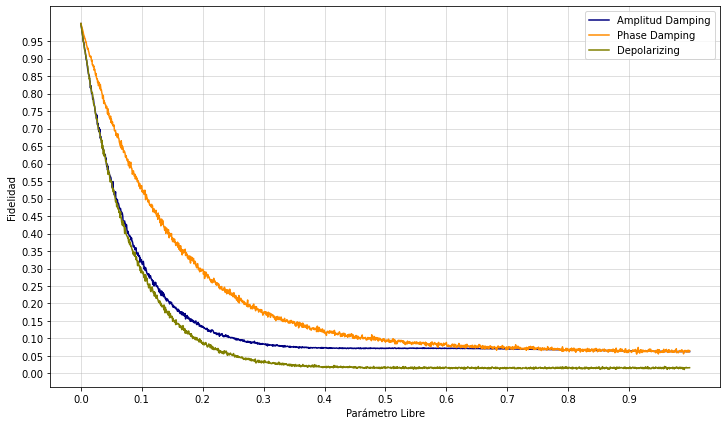

In [41]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_i, f_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_i, f_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_i, f_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()